# Day 09. Exercise 03
# Ensembles

## 0. Imports

In [172]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import BaggingClassifier, StackingClassifier

from itertools import combinations_with_replacement, combinations, product
from tqdm.notebook import tqdm, trange
import joblib

In [34]:
def print_scores(y_real, y_pred):
    print(f"accuracy:  {accuracy_score(y_real, y_pred):.5f}")
    print(f"precision: {precision_score(y_real, y_pred, average='weighted'):.5f}")
    print(f"recall:    {recall_score(y_real, y_pred, average='weighted'):.5f}")

In [35]:
def calc_metrics(models, params):
    for model_, params_ in zip(models, params):
        clf = model_(random_state=21, **params_).fit(X_train, y_train)
        print(type(clf).__name__)
        print_scores(y_test, clf.predict(X_test))
        print('----------------------------')

## 1. Preprocessing

1. Create the same dataframe as in the previous exercise.
2. Using `train_test_split` with parameters `test_size=0.2`, `random_state=21` get `X_train`, `y_train`, `X_test`, `y_test` and then get `X_train`, `y_train`, `X_valid`, `y_valid` from the previous `X_train`, `y_train`. Use the additional parameter `stratify`.

In [3]:
df = pd.read_csv('../data/dayofweek-not-scaled.csv')
X, y = df.drop(columns=['dayofweek']), df.dayofweek

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2,
                                                    random_state=21,
                                                    stratify=y)

## 2. Individual classifiers

1. Train SVM, decision tree and random forest again with the best parameters that you got from the 01 exercise with `random_state=21` for all of them.
2. Evaluate `accuracy`, `precision`, and `recall` for them on the validation set.
3. The result of each cell of the section should look like this:

```
accuracy is 0.87778
precision is 0.88162
recall is 0.87778
```

In [36]:
models = [SVC, DecisionTreeClassifier, RandomForestClassifier]
params = [
    {'kernel':'rbf', 'gamma':'auto', 'class_weight':None, 'C':10, 'probability':True},
    {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 22},
    {'class_weight': None, 'criterion': 'gini', 'max_depth': 28, 'n_estimators': 50}
]
calc_metrics(models, params)

SVC
accuracy:  0.88757
precision: 0.89267
recall:    0.88757
----------------------------
DecisionTreeClassifier
accuracy:  0.89053
precision: 0.89262
recall:    0.89053
----------------------------
RandomForestClassifier
accuracy:  0.92899
precision: 0.93009
recall:    0.92899
----------------------------


In [24]:
clf_svc = SVC(random_state=21, kernel='rbf', gamma='auto',
              class_weight=None, C=10, probability=True)
clf_tree = DecisionTreeClassifier(random_state=21, class_weight='balanced',
                                  criterion='gini', max_depth=22)
clf_forest = RandomForestClassifier(random_state=21, class_weight=None, criterion='gini',
                                    max_depth=28, n_estimators=50)

## 3. Voting classifiers

1. Using `VotingClassifier` and the three models that you have just trained, calculate the `accuracy`, `precision`, and `recall` on the validation set.
2. Play with the other parameteres.
3. Calculate the `accuracy`, `precision` and `recall` on the test set for the model with the best weights in terms of accuracy (if there are several of them with equal values, choose the one with the higher precision).

In [38]:
vote = VotingClassifier([('svc', clf_svc),
                         ('tree', clf_tree),
                         ('forest', clf_forest)]
                       ).fit(X_train, y_train)
y_pred = vote.predict(X_test)
print_scores(y_test, y_pred)

accuracy:  0.92308
precision: 0.92399
recall:    0.92308


In [41]:
vote = VotingClassifier([('svc', clf_svc),
                         ('tree', clf_tree),
                         ('forest', clf_forest)],
                        voting='soft'
                       ).fit(X_train, y_train)
y_pred = vote.predict(X_test)
print_scores(y_test, y_pred)

accuracy:  0.90828
precision: 0.91030
recall:    0.90828


In [95]:
weights_grid = list(product(range(1, 7), repeat=3))
weights_grid = list(filter(lambda x: any(elem != x[0] for elem in x), weights_grid))
weights_grid = list(filter(lambda x: not all(elem % 2 == 0 for elem in x), weights_grid))
# weights_grid

In [101]:
best_weigths = {}
best_accuracy = .0
best_precision = .0

for weights in tqdm(weights_grid):
    vote_w = VotingClassifier([('svc', clf_svc),
                               ('tree', clf_tree),
                               ('forest', clf_forest)],
                              weights=weights
                             ).fit(X_train, y_train)
    y_pred = vote_w.predict(X_test)
    accur_score = accuracy_score(y_test, y_pred)
    precis_score = precision_score(y_test, y_pred, average='weighted')
    if accur_score > best_accuracy or \
    (accur_score == best_accuracy and best_precision < precis_score):
        best_accuracy = accur_score
        best_precision = precis_score
        best_weigths.clear()
        best_weigths[weights] = precis_score


for weights in tqdm(best_weigths.keys()):
    vote = VotingClassifier([('svc', clf_svc),
                             ('tree', clf_tree),
                             ('forest', clf_forest)],
                            weights=weights
                           ).fit(X_train, y_train)
    print(*weights)
    print_scores(y_test, vote.predict(X_test))
    print('---------------------')

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2 3 2
accuracy:  0.92899
precision: 0.93024
recall:    0.92899
---------------------


In [102]:
best_case = VotingClassifier([('svc', clf_svc),
                              ('tree', clf_tree),
                              ('forest', clf_forest)],
                             weights=[2, 3, 2]
                            ).fit(X_train, y_train)
print_scores(y_test, vote.predict(X_test))

accuracy:  0.92899
precision: 0.93024
recall:    0.92899


## 4. Bagging classifiers

1. Using `BaggingClassifier` and `SVM` with the best parameters create an ensemble, try different values of the `n_estimators`, use `random_state=21`.
2. Play with the other parameters.
3. Calculate the `accuracy`, `precision`, and `recall` for the model with the best parameters (in terms of accuracy) on the test set (if there are several of them with equal values, choose the one with the higher precision)

In [104]:
clf_svc = SVC(kernel='rbf', gamma='auto', class_weight=None, C=10,
              probability=True, random_state=21)

In [111]:
best_estimators = {}
best_accuracy = .0
best_precision = .0

for i in trange(5, 51, 5):
    clf_bag = BaggingClassifier(clf_svc, random_state=21, n_estimators=i).fit(X_train, y_train)
    y_pred = clf_bag.predict(X_test)
    accur_score = accuracy_score(y_test, y_pred)
    precis_score = precision_score(y_test, y_pred, average='weighted')
    if accur_score > best_accuracy or \
    (accur_score == best_accuracy and best_precision < precis_score):
        best_accuracy = accur_score
        best_precision = precis_score
        best_estimators.clear()
        best_estimators[i] = precis_score
        
for i in trange(50, 151, 10):
    clf_bag = BaggingClassifier(clf_svc, random_state=21, n_estimators=i).fit(X_train, y_train)
    y_pred = clf_bag.predict(X_test)
    accur_score = accuracy_score(y_test, y_pred)
    precis_score = precision_score(y_test, y_pred, average='weighted')
    if accur_score > best_accuracy or \
    (accur_score == best_accuracy and best_precision < precis_score):
        best_accuracy = accur_score
        best_precision = precis_score
        best_estimators.clear()
        best_estimators[i] = precis_score
        

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [114]:
for i in tqdm(best_estimators.keys()):
    clf_bag = BaggingClassifier(clf_svc, random_state=21, n_estimators=i).fit(X_train, y_train)
    print(i)
    print_scores(y_test, clf_bag.predict(X_test))
    print('---------------------')

  0%|          | 0/1 [00:00<?, ?it/s]

50
accuracy:  0.90828
precision: 0.91091
recall:    0.90828
---------------------


In [125]:
clf_bag = BaggingClassifier(clf_svc, random_state=21, n_jobs=-1, n_estimators=50
                           ).fit(X_train, y_train)
print_scores(y_test, clf_bag.predict(X_test))

accuracy:  0.90828
precision: 0.91091
recall:    0.90828


## 5. Stacking classifiers

1. To achieve reproducibility in this case you will have to create an object of cross-validation generator: `StratifiedKFold(n_splits=n, shuffle=True, random_state=21)`, where `n` you will try to optimize (the details are below).
2. Using `StackingClassifier` and the three models that you have recently trained, calculate the `accuracy`, `precision` and `recall` on the validation set, try different values of `n_splits` `[2, 3, 4, 5, 6, 7]` in the cross-validation generator and parameter `passthrough` in the classifier itself,
3. Calculate the `accuracy`, `precision`, and `recall` for the model with the best parameters (in terms of accuracy) on the test set (if there are several of them with equal values, choose the one with the higher precision). Use `final_estimator=LogisticRegression(solver='liblinear')`.

In [154]:
def crossval(Model, X, y, n_splits = [10]):
    accur_scores = []
    precis_scores = []
    recall_scores = []
    for splits in tqdm(n_splits):
        kf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=21)
        for train, test in kf.split(X, y):
            clf = Model.fit(X.iloc[train], y.iloc[train])
            y_test_pred = clf.predict(X.iloc[test])
            
            accuracy = accuracy_score(y.iloc[test], y_test_pred)
            precision = precision_score(y.iloc[test], y_test_pred, average='weighted')
            recall = recall_score(y.iloc[test], y_test_pred, average='weighted')
#             print(f'accuracy, precision, recall - {accuracy:.5f}, {precision:.5f}, {recall:.5f}')
            accur_scores.append(accuracy)
            precis_scores.append(precision)
            recall_scores.append(recall)
        print(f'\nn_splits = {splits}')
        print(f'Average accuracy on crossval is  {np.mean(accur_scores):.5f}')
        print(f'Average precision on crossval is {np.mean(precis_scores):.5f}')
        print(f'Average recall on crossval is    {np.mean(recall_scores):.5f}')
        print('------------------------------------------------------')

In [128]:
clf_stack = StackingClassifier([('svc', clf_svc),
                                ('tree', clf_tree),
                                ('forest', clf_forest)])

In [142]:
crossval(clf_stack, X_train, y_train, range(2, 8))

  0%|          | 0/6 [00:00<?, ?it/s]


n_splits = 2
Average accuracy on crossval is  0.86499
Average precision on crossval is 0.86659
Average recall on crossval is    0.86499
------------------------------------------------------

n_splits = 3
Average accuracy on crossval is  0.87521
Average precision on crossval is 0.87719
Average recall on crossval is    0.87521
------------------------------------------------------

n_splits = 4
Average accuracy on crossval is  0.88880
Average precision on crossval is 0.89103
Average recall on crossval is    0.88880
------------------------------------------------------

n_splits = 5
Average accuracy on crossval is  0.89725
Average precision on crossval is 0.89935
Average recall on crossval is    0.89725
------------------------------------------------------

n_splits = 6
Average accuracy on crossval is  0.90181
Average precision on crossval is 0.90420
Average recall on crossval is    0.90181
------------------------------------------------------

n_splits = 7
Average accuracy on crossv

In [162]:
clf_stack_passthrough = StackingClassifier([
    ('svc', clf_svc),
    ('tree', clf_tree),
    ('forest', clf_forest)],
    passthrough=True, final_estimator=LogisticRegression(solver='liblinear')
)
crossval(clf_stack_passthrough, X_train, y_train, range(2, 8))

  0%|          | 0/6 [00:00<?, ?it/s]


n_splits = 2
Average accuracy on crossval is  0.86869
Average precision on crossval is 0.87123
Average recall on crossval is    0.86869
------------------------------------------------------

n_splits = 3
Average accuracy on crossval is  0.88248
Average precision on crossval is 0.88481
Average recall on crossval is    0.88248
------------------------------------------------------

n_splits = 4
Average accuracy on crossval is  0.89383
Average precision on crossval is 0.89589
Average recall on crossval is    0.89383
------------------------------------------------------

n_splits = 5
Average accuracy on crossval is  0.89969
Average precision on crossval is 0.90188
Average recall on crossval is    0.89969
------------------------------------------------------

n_splits = 6
Average accuracy on crossval is  0.90285
Average precision on crossval is 0.90541
Average recall on crossval is    0.90285
------------------------------------------------------

n_splits = 7
Average accuracy on crossv

In [163]:
clf_stack_final = StackingClassifier([
    ('svc', clf_svc),
    ('tree', clf_tree),
    ('forest', clf_forest)],
    passthrough=True, final_estimator=LogisticRegression(solver='liblinear')
).fit(X_train, y_train)
print_scores(y_test, clf_stack_final.predict(X_test))

accuracy:  0.92899
precision: 0.93200
recall:    0.92899


## 6. Predictions

1. Choose the best model in terms of accuracy (if there are several of them with equal values, choose the one with the higher precision).
2. Analyze: for which weekday your model makes the most errors (in % of the total number of samples of that class in your full dataset), for which labname and for which users.
3. Save the model.

> `StackingClassifier` had the best results in terms of accuracy

In [165]:
y_pred = clf_stack_final.predict(X_test)

compare = pd.DataFrame({'y_real': y_test, 'y_pred': y_pred})
stats = compare.y_real[compare['y_real'] != compare['y_pred']].value_counts().sort_index()
stats

0    7
1    6
2    2
3    2
4    1
5    5
6    1
Name: y_real, dtype: int64

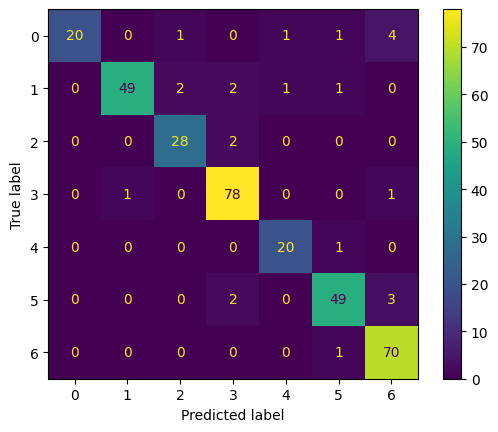

In [169]:
disp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred, labels=clf_stack_final.classes_),
    display_labels=clf_stack_final.classes_
)
disp.plot()
plt.show()

> Most of all incorrectly predicted is on `Mondays` - `7` (`25.92%`), then `Tuesdays` - `6` (`10.9%`).

In [173]:
joblib.dump(clf_stack_final, 'StackingClassifier.joblib')

['StackingClassifier.joblib']